## Amazon product review dataset

Source: https://www.kaggle.com/skillsmuggler/amazon-ratings

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")

import sklearn
from sklearn.decomposition import TruncatedSVD

#### Loading the dataset

In [2]:
amazon_ratings = pd.read_csv('ratings_Beauty.csv')
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [3]:
amazon_ratings.shape

(2023070, 4)

In [4]:
popular_products = pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


<Axes: xlabel='ProductId'>

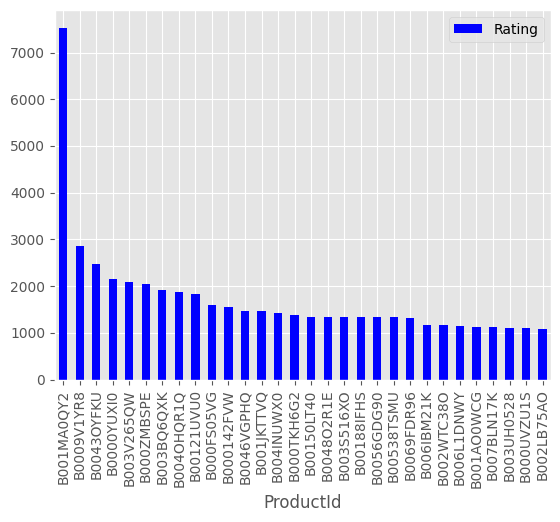

In [5]:
most_popular.head(30).plot(kind = "bar", color="blue")

##### Analysis:

The above graph gives us the most popular products (arranged in descending order) sold by the business.

For eaxmple, product, ID # B001MA0QY2 has sales of over 7000, the next most popular product, ID # B0009V1YR8 has sales of  3000, etc.     

### Model-based collaborative filtering system



A model based collaborative filtering technique is closen here as it helps in making predictinfg products for a particular user by identifying patterns based on preferences from multiple user data.

#### Utility Matrix based on products sold and user reviews

Utility Matrix

An utlity matrix is consists of all possible user-item preferences (ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all teh items in the list, hence, most of the values are unknown.

In [6]:
# Subset of Amazon Ratings

amazon_ratings1 = amazon_ratings.head(10000)

In [7]:
ratings_utility_matrix = amazon_ratings1.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A024581134CV80ZBLIZTZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A03056581JJIOL5FSKJY7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A03099101ZRK4K607JVHH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0505229A7NSH3FRXRR4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.

In [8]:
ratings_utility_matrix.shape

(9697, 886)

Transposing the matrix

In [9]:
X = ratings_utility_matrix.T
X.head()

UserId,A00205921JHJK5X9LNP42,A024581134CV80ZBLIZTZ,A03056581JJIOL5FSKJY7,A03099101ZRK4K607JVHH,A0505229A7NSH3FRXRR4,A05492663T95KW63BR75K,A059547920Q3LZVFHLPI3,A07410232KYRFR25CIUGJ,A082796624UNM47DSAI6K,A0864963DOAY7LXGS5I6,...,AZW1HXXYAC15B,AZWRTJPN7NXT,AZWTXHXZXFAYP,AZYQEFB9Y5N22,AZZHB6U54UDYW,AZZHJZP4GQPPZ,AZZNK89PXD006,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZTJQ7CQZUD8
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0558925278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0733001998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0737104473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0762451459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X.shape

(886, 9697)

Unique products in subset of data

In [11]:
X1 = X

### Decomposing the Matrix

In [12]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(886, 10)

### Correlation Matrix

In [13]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(886, 886)

correlation_matrix

### Isolating Product ID # 6117036094 from the Correlation Matrix

Assuming the customer buys Product ID # 6117036094 (randomly chosen)

In [14]:
X.index[99]

'6117036094'

Index # of product ID purchased by customer

In [16]:
i = "6117036094"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

99

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [17]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(886,)

### Recommending top 10 highly correlated products in sequence

In [18]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:9]

['0205616461',
 '130414089X',
 '1304351475',
 '1412759676',
 '1987958179',
 '3227001055',
 '3227001381',
 '3292000971',
 '360211600X']

Product Id #

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website. 

For a business without any user-item purchase history, a search engine based recommendation system can be designed for users. The product recommendations can be based on textual clustering analysis given in product description.

In [19]:
# Importing libraries

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

## Home Depot's dataset with product dataset:

https://www.kaggle.com/c/home-depot-product-search-relevance/data

### Item to item based recommendation system based on product description

Applicable when business is setting up its E-commerce website for the first time

In [20]:
product_descriptions = pd.read_csv('product_descriptions.csv')
product_descriptions.shape

(124428, 2)

#### Checking for missing values

In [21]:
# Missing values

product_descriptions = product_descriptions.dropna()
product_descriptions.shape
product_descriptions.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [22]:
product_descriptions1 = product_descriptions.head(500)
# product_descriptions1.iloc[:,1]

product_descriptions1["product_description"].head(10)

0    Not only do angles make joints stronger, they ...
1    BEHR Premium Textured DECKOVER is an innovativ...
2    Classic architecture meets contemporary design...
3    The Grape Solar 265-Watt Polycrystalline PV So...
4    Update your bathroom with the Delta Vero Singl...
5    Achieving delicious results is almost effortle...
6    The Quantum Adjustable 2-Light LED Black Emerg...
7    The Teks #10 x 1-1/2 in. Zinc-Plated Steel Was...
8    Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...
9    Valley View Industries Metal Stakes (4-Pack) a...
Name: product_description, dtype: object

#### Feature extraction from product descriptions

Converting the text in product description into numerical data for analysis

In [23]:
vectorizer = TfidfVectorizer(stop_words='english')
X1 = vectorizer.fit_transform(product_descriptions1["product_description"])
X1

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 34817 stored elements and shape (500, 8932)>

#### Visualizing product clusters in subset of data

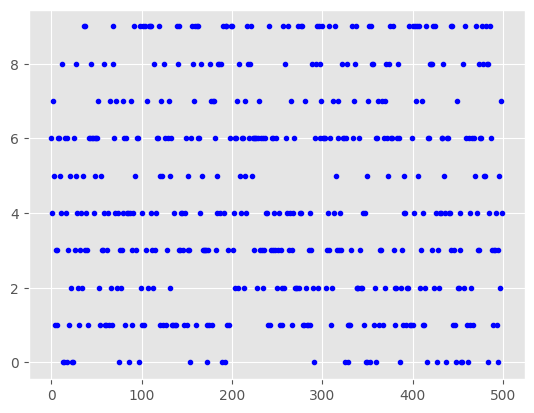

In [24]:
# Fitting K-Means to the dataset

X=X1

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".", color="blue")
plt.show()


#### Top words in each cluster based on product description

In [27]:
true_k = 10

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X1)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()  # <-- Updated here

for i in range(true_k):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print()


Top terms per cluster:
Cluster 0:
 storage
 shelves
 lbs
 steel
 shelf
 adjustable
 unit
 capacity
 duty
 weight

Cluster 1:
 piece
 water
 toilet
 finish
 design
 use
 outdoor
 flush
 natural
 recommended

Cluster 2:
 light
 watt
 led
 bulb
 bulbs
 fan
 lighting
 fixture
 white
 depot

Cluster 3:
 power
 air
 cutting
 cooling
 control
 plan
 snow
 engine
 ft
 protection

Cluster 4:
 door
 cooking
 easy
 cu
 oven
 cycle
 wash
 opening
 energy
 steam

Cluster 5:
 watering
 water
 easy
 plants
 shower
 spray
 head
 handle
 use
 gal

Cluster 6:
 wood
 window
 patio
 outdoor
 bamboo
 natural
 collection
 frame
 available
 rug

Cluster 7:
 wall
 panels
 ft
 moulding
 mdf
 home
 room
 painted
 easy
 plate

Cluster 8:
 metal
 concrete
 insulation
 water
 ft
 paint
 seal
 use
 used
 fiberglass

Cluster 9:
 20
 lithium
 m12
 battery
 ion
 impact
 volt
 max
 tool
 compact



#### Predicting clusters based on key search words

cutting tool

In [28]:
print("Cluster ID:")
Y = vectorizer.transform(["cutting tool"])
prediction = model.predict(Y)
print(prediction)

Cluster ID:
[3]


spray paint

In [29]:
print("Cluster ID:")
Y = vectorizer.transform(["spray paint"])
prediction = model.predict(Y)
print(prediction)

Cluster ID:
[5]


steel drill

In [30]:
print("Cluster ID:")
Y = vectorizer.transform(["steel drill"])
prediction = model.predict(Y)
print(prediction)

Cluster ID:
[8]


In case a word appears in multiple clusters, the algorithm chooses the cluster with the highest frequency of occurance of the word.

water

In [31]:
print("Cluster ID:")
Y = vectorizer.transform(["water"])
prediction = model.predict(Y)
print(prediction)

Cluster ID:
[5]


Once a cluster is identified based on the user's search words, the recommendation system can display items from the corresponding product clusters based on the product descriptions.